In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import os

import warnings
warnings.filterwarnings('ignore')

Parcel data sourced from CAGIS Open Data Portal: https://data-cagisportal.opendata.arcgis.com/datasets/b425fe9411ea46a0987bc3a62101a90e_4/explore

Census tract shapefiles shared by Junia


In [2]:
parcels = gpd.read_file(r"C:\Users\mihir\Downloads\Hamilton_County_Parcels\Parcel_Merged_Consolidations.shp")

# Census tracts (shared by Junia)
tracts = gpd.read_file(r"C:\Users\mihir\Downloads\tl_2020_39_tract (1)\tl_2020_39_tract.shp")


In [3]:
# Restrict tracts data to just hamilton county for faster processing 
tracts['countyfips'] = tracts['STATEFP'] + tracts['COUNTYFP']
tracts_hamilton = tracts[tracts['countyfips'] == '39061']
tracts_hamilton.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,countyfips
90,39,061,005200,39061005200,52,Census Tract 52,G5020,S,1196420,0,+39.1509156,-084.4371694,"POLYGON ((-84.44284 39.14488, -84.44283 39.144...",39061
91,39,061,026200,39061026200,262,Census Tract 262,G5020,S,25146789,1501363,+39.1821574,-084.7698796,"POLYGON ((-84.82017 39.12219, -84.82013 39.124...",39061
92,39,061,023901,39061023901,239.01,Census Tract 239.01,G5020,S,4665315,18888,+39.2555417,-084.3491076,"POLYGON ((-84.36621 39.24994, -84.36614 39.250...",39061
128,39,061,023701,39061023701,237.01,Census Tract 237.01,G5020,S,1190501,0,+39.2066669,-084.3981095,"POLYGON ((-84.40871 39.20492, -84.40864 39.205...",39061
147,39,061,010500,39061010500,105,Census Tract 105,G5020,S,935849,0,+39.1107416,-084.6858406,"POLYGON ((-84.69532 39.11377, -84.69502 39.113...",39061


In [4]:
print(parcels.crs)
print(tracts_hamilton.crs)

EPSG:3857
EPSG:4269


In [5]:
# Correcting projections
tracts_hamilton['geometry'] = tracts_hamilton['geometry'].to_crs(epsg=3857)
parcels.crs == tracts_hamilton.crs

True

In [6]:
# Print rows before join
print(f"Length of parcels data pre-join: {len(parcels)}")

# Perform a spatial join between the two to get parcel - tract mapping
parcel_tract_join = parcels.sjoin(tracts_hamilton, how="inner", predicate='intersects')

# Print rows after join
print(f"Length of parcels data post-join: {len(parcel_tract_join)}")



Length of parcels data pre-join: 354007
Length of parcels data post-join: 363857


<AxesSubplot: >

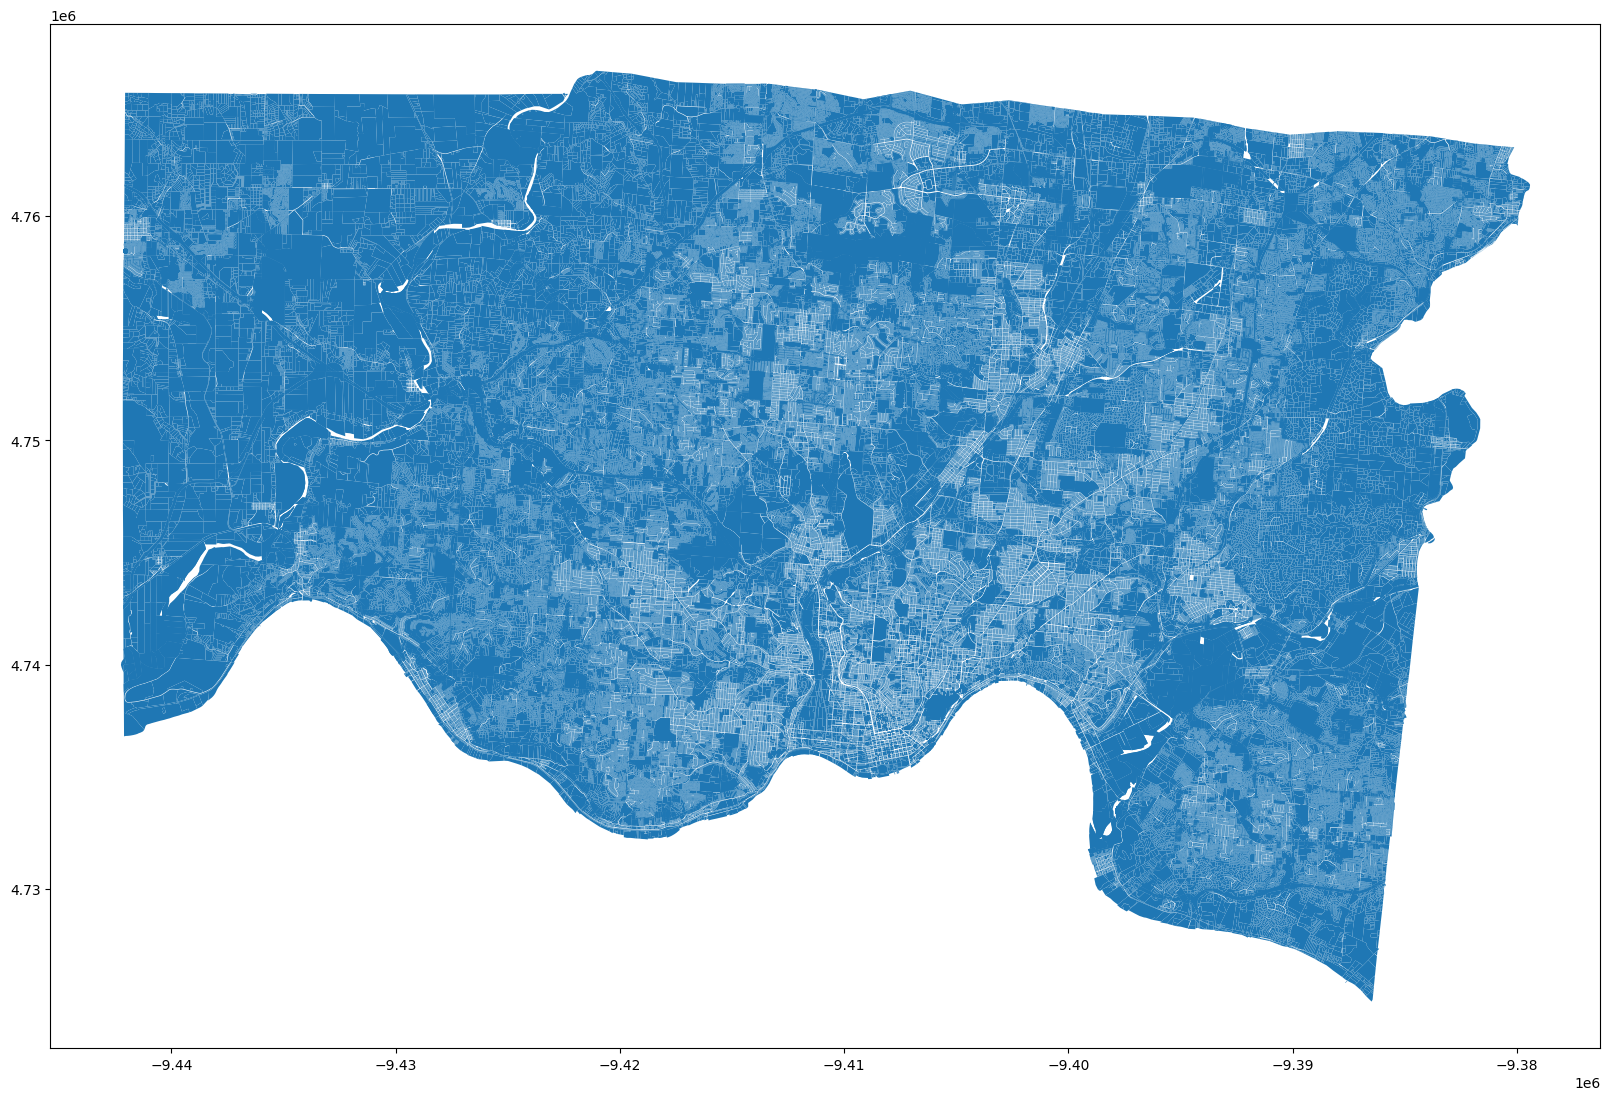

In [7]:
# Plotting to make sure all okay
plt.rcParams["figure.figsize"]=20,20
parcel_tract_join.plot()

In [8]:
# Pulling in demographic info
demo = pd.read_csv(r"C:\Users\mihir\Downloads\censustractdemographics2020.csv", encoding='latin-1')

# Extracting tract from geography (everything before the first comma)
demo['tract'] = demo['geography'].str.extract('([^,]+)')

# Now joining this demographic info with the merged parcel info
parcel_tract_join['countyfips'] = parcel_tract_join['countyfips'].astype(int)


final_df = pd.merge(parcel_tract_join, demo, how='inner', left_on=['countyfips', 'NAMELSAD'], right_on=['county', 'tract'])

print(len(final_df))

363857


In [9]:
final_df

,OBJECTID,GRPPCLID,BOOK,PAGE,PARCEL,MLTOWN,PARCELID,PROPTYID,AUDPCLID,AUDPTYID,...,whitepro,blackpro,indigenouspro,latinxpro,asianpro,raceotherpro,owneroccpro,vacantpro,singlefampro,tract
0,1,000100010038,001,0001,0038,0.0,000100010038,00010001003800,00100010038,0010001003800,...,0.838759,0.053154,0.0,0.050356,0.009410,0.048322,0.575467,0.055467,0.479467,Census Tract 46.04
1,2,000100010039,001,0001,0039,0.0,000100010039,00010001003900,00100010039,0010001003900,...,0.838759,0.053154,0.0,0.050356,0.009410,0.048322,0.575467,0.055467,0.479467,Census Tract 46.04
2,3,000100010040,001,0001,0040,0.0,000100010040,00010001004000,00100010040,0010001004000,...,0.838759,0.053154,0.0,0.050356,0.009410,0.048322,0.575467,0.055467,0.479467,Census Tract 46.04
3,4,000100010041,001,0001,0041,0.0,000100010041,00010001004100,00100010041,0010001004100,...,0.838759,0.053154,0.0,0.050356,0.009410,0.048322,0.575467,0.055467,0.479467,Census Tract 46.04
4,5,000100010042,001,0001,0042,0.0,000100010042,00010001004200,00100010042,0010001004200,...,0.838759,0.053154,0.0,0.050356,0.009410,0.048322,0.575467,0.055467,0.479467,Census Tract 46.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363852,353776,06200190CD30,620,0190,0706,0.0,062001900706,06200190070600,62001900706,6200190070600,...,0.830482,0.082204,0.0,0.040213,0.029105,0.017996,0.683604,0.032478,0.568360,Census Tract 243.24
363853,353777,06200190CD30,620,0190,0710,0.0,062001900710,06200190071000,62001900710,6200190071000,...,0.830482,0.082204,0.0,0.040213,0.029105,0.017996,0.683604,0.032478,0.568360,Census Tract 243.24
363854,353778,06200190CD30,620,0190,0716,0.0,062001900716,06200190071600,62001900716,6200190071600,...,0.830482,0.082204,0.0,0.040213,0.029105,0.017996,0.683604,0.032478,0.568360,Census Tract 243.24
363855,353779,06200190CD30,620,0190,0717,0.0,062001900717,06200190071700,62001900717,6200190071700,...,0.830482,0.082204,0.0,0.040213,0.029105,0.017996,0.683604,0.032478,0.568360,Census Tract 243.24


In [18]:
# Creating correct parcelid
final_df['MLTOWN'] = final_df['MLTOWN'].fillna(0)


final_df['parcelid'] = final_df.apply(lambda row: str(row['BOOK']).zfill(3) +
                                                      str(row['PAGE']).zfill(4) +
                                                      str(row['PARCEL']).zfill(4) +
                                                      str(int(row['MLTOWN'])).zfill(2), axis=1)

final_df[['parcelid', 'PARCELID', 'BOOK', 'PAGE', 'PARCEL', 'MLTOWN']]

,parcelid,PARCELID,BOOK,PAGE,PARCEL,MLTOWN
0,0010001003800,000100010038,001,0001,0038,0.0
1,0010001003900,000100010039,001,0001,0039,0.0
2,0010001004000,000100010040,001,0001,0040,0.0
3,0010001004100,000100010041,001,0001,0041,0.0
4,0010001004200,000100010042,001,0001,0042,0.0
...,...,...,...,...,...,...
363852,6200190070600,062001900706,620,0190,0706,0.0
363853,6200190071000,062001900710,620,0190,0710,0.0
363854,6200190071600,062001900716,620,0190,0716,0.0
363855,6200190071700,062001900717,620,0190,0717,0.0


In [19]:
final_df_clean = final_df[['parcelid', 'GEOID','countyfips','TRACTCE', 'tract','medianincome', 'poverty', 'total', 'whitepro', 'blackpro', 'indigenouspro',
                           'latinxpro', 'asianpro', 'raceotherpro', 'owneroccpro', 'vacantpro', 'singlefampro']]

final_df_clean


,parcelid,GEOID,countyfips,TRACTCE,tract,medianincome,poverty,total,whitepro,blackpro,indigenouspro,latinxpro,asianpro,raceotherpro,owneroccpro,vacantpro,singlefampro
0,0010001003800,39061004604,39061,004604,Census Tract 46.04,48966.0,19.9,3932,0.838759,0.053154,0.0,0.050356,0.009410,0.048322,0.575467,0.055467,0.479467
1,0010001003900,39061004604,39061,004604,Census Tract 46.04,48966.0,19.9,3932,0.838759,0.053154,0.0,0.050356,0.009410,0.048322,0.575467,0.055467,0.479467
2,0010001004000,39061004604,39061,004604,Census Tract 46.04,48966.0,19.9,3932,0.838759,0.053154,0.0,0.050356,0.009410,0.048322,0.575467,0.055467,0.479467
3,0010001004100,39061004604,39061,004604,Census Tract 46.04,48966.0,19.9,3932,0.838759,0.053154,0.0,0.050356,0.009410,0.048322,0.575467,0.055467,0.479467
4,0010001004200,39061004604,39061,004604,Census Tract 46.04,48966.0,19.9,3932,0.838759,0.053154,0.0,0.050356,0.009410,0.048322,0.575467,0.055467,0.479467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363852,6200190070600,39061024324,39061,024324,Census Tract 243.24,86507.0,4.4,4501,0.830482,0.082204,0.0,0.040213,0.029105,0.017996,0.683604,0.032478,0.568360
363853,6200190071000,39061024324,39061,024324,Census Tract 243.24,86507.0,4.4,4501,0.830482,0.082204,0.0,0.040213,0.029105,0.017996,0.683604,0.032478,0.568360
363854,6200190071600,39061024324,39061,024324,Census Tract 243.24,86507.0,4.4,4501,0.830482,0.082204,0.0,0.040213,0.029105,0.017996,0.683604,0.032478,0.568360
363855,6200190071700,39061024324,39061,024324,Census Tract 243.24,86507.0,4.4,4501,0.830482,0.082204,0.0,0.040213,0.029105,0.017996,0.683604,0.032478,0.568360


In [21]:
# Writing table to dataframe
db_str = os.getenv('ERUKA_DB')

db = create_engine(db_str)

db.execute("drop table if exists census_demographics;")

final_df_clean.to_sql('census_demographics', db, index=False)

857